# Designing a synthesis route and executing it on a robot
In this example we show how to use the endpoints of the `rxn4chemistry` package. 
- We start from a target molecule in SMILES format.
- We then use the models to predict a retrosynthetic path.
- Once we have chosen the desired path, we start a new synthesis on the robotic hardware.
- We monitor the progress of the execution and finally download a pdf report from the analysis.

## Setup the logger

In [89]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s : %(message)s')

## Instantiating the wrapper
Setup the wrapper using a valida API key. You can get one on the IBM RXN website from [here](https://rxn.res.ibm.com/rxn/user/profile).

In [90]:
from rxn4chemistry import RXN4ChemistryWrapper
api_key = 'API_KEY'
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)

## Create a project

Create a project, you can easily check the identifier associated to it in the response.

In [91]:
response = rxn4chemistry_wrapper.create_project('rxn4chemistry_examples')

INFO : Set project id to 63e4b16c54f4ba001fea678d


You can get your project id from the wrapper

In [92]:
rxn4chemistry_wrapper.project_id

'63e4b16c54f4ba001fea678d'

## Run a retrosynthesis prediction using the wrapper
Running a retrosynthesis is as easy as picking a molecule and calling a one-liner.

In this example, we will be predicting a path for [4-Bromoacetanilide](https://www.chemsynthesis.com/base/chemical-structure-2.html).

In [93]:
smiles = 'CC(=O)NC1=CC=C(Br)C=C1'
response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(product=smiles, ai_model='2019-09-12')

### Check status and get the results
Rerun the following command until the status is 'SUCCESS', keep in mind the server allows only 5 requests per minute
and a timeout between consecutive requests of 2 seconds

In [98]:
results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(response['prediction_id'])
results['status']

'SUCCESS'

Upon 'SUCCESS' we can choose one of the returned retrosynthetic paths. The paths are sorted based on the scoring mechanism of the models.

In [100]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import display


def collect_reactions(tree):
    reactions = []
    if 'children' in tree and len(tree['children']):
        reactions.append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )
    for node in tree['children']:
        reactions.extend(collect_reactions(node))
    return reactions

Showing path 0 with confidence 0.964:


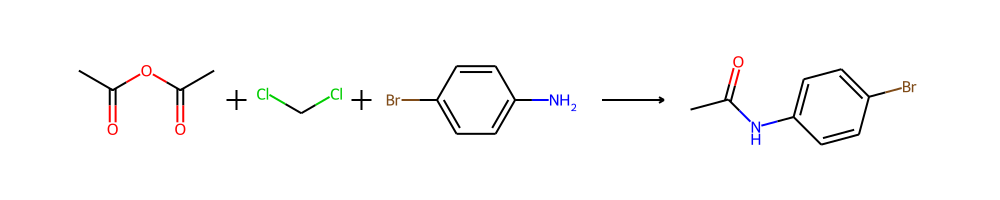

Showing path 1 with confidence 0.964:


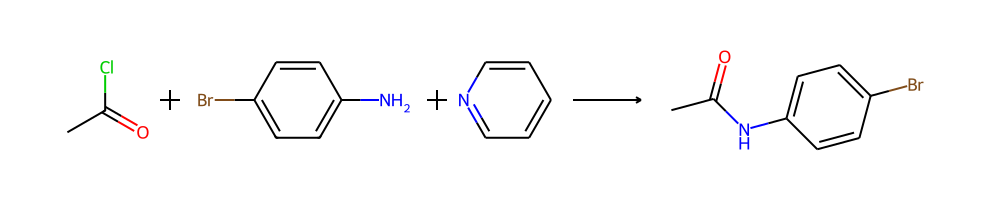

Showing path 2 with confidence 0.962:


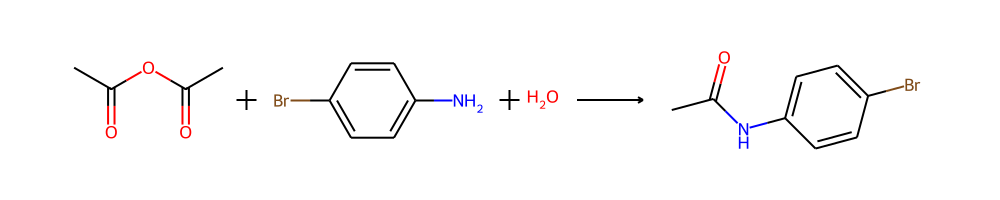

Showing path 3 with confidence 0.96:


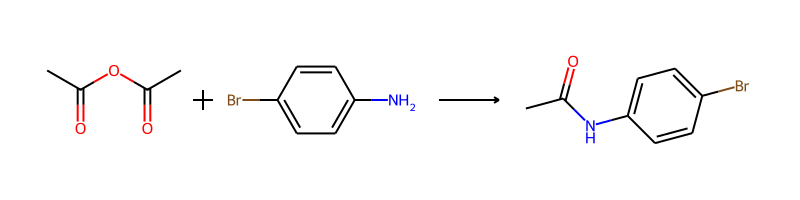

Showing path 4 with confidence 0.959:


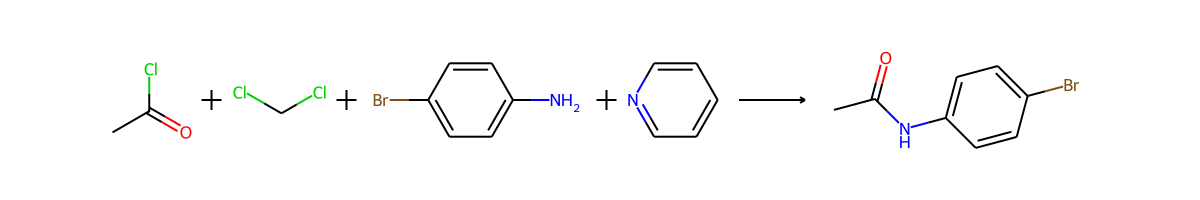

Showing path 5 with confidence 0.958:


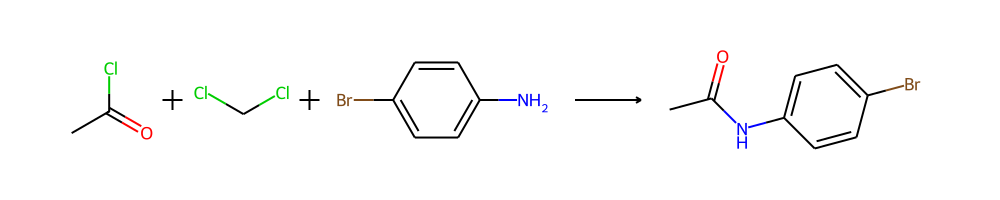

Showing path 6 with confidence 0.956:


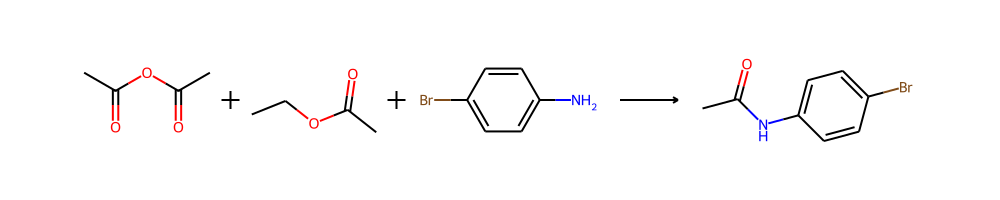

Showing path 7 with confidence 0.955:


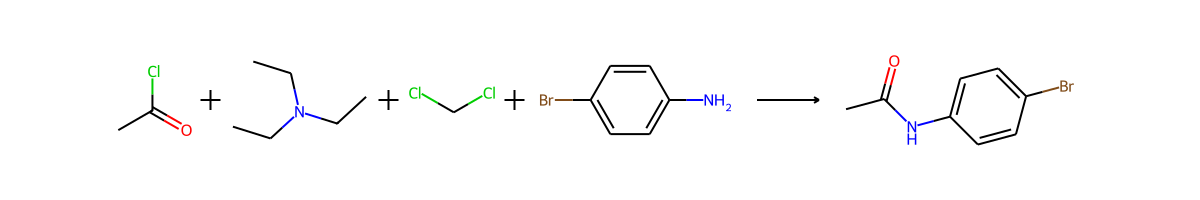

Showing path 8 with confidence 0.955:


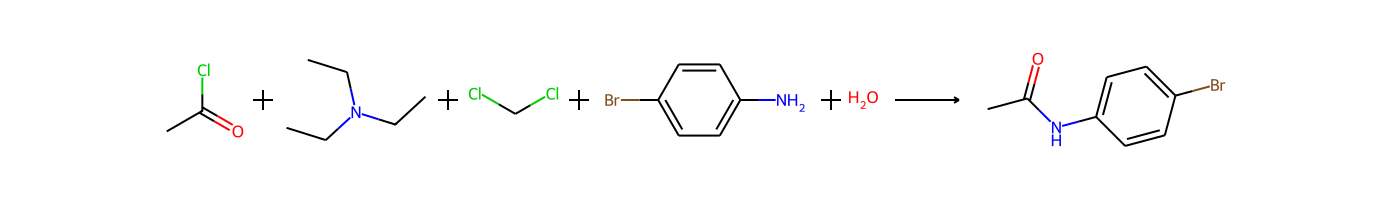

Showing path 9 with confidence 0.953:


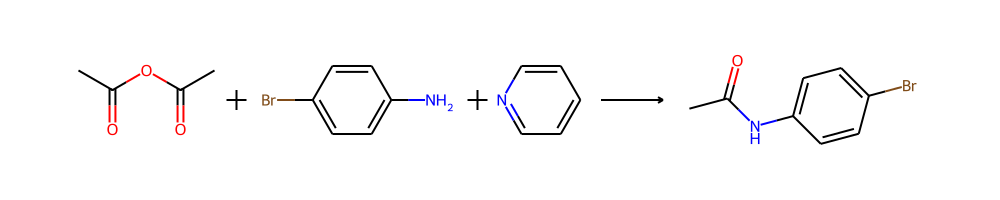

Showing path 10 with confidence 0.951:


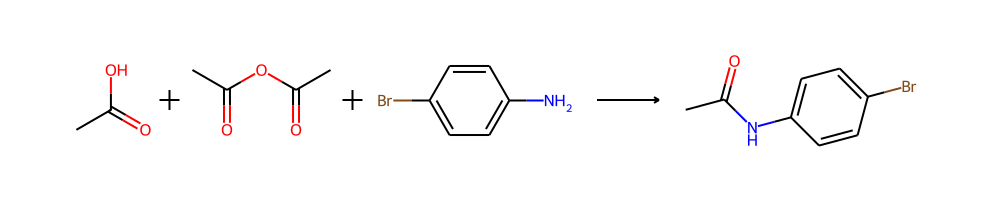

Showing path 11 with confidence 0.95:


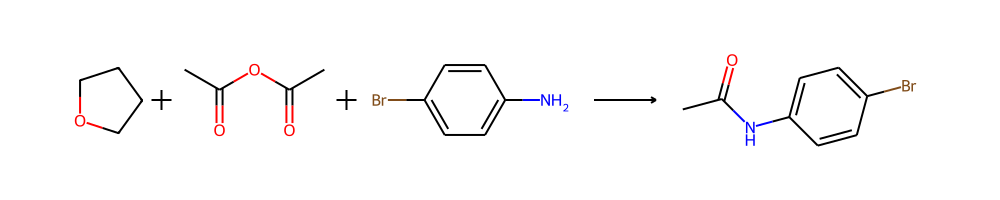

Showing path 12 with confidence 0.949:


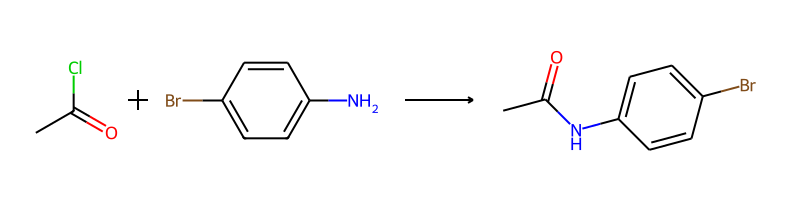

Showing path 13 with confidence 0.625:


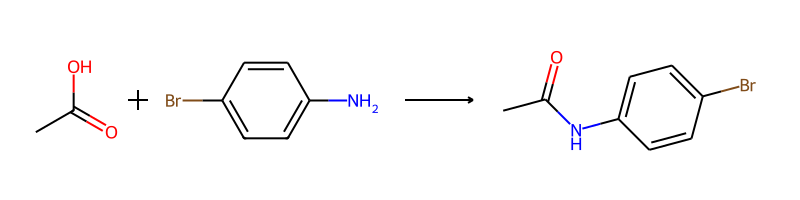

In [101]:
for index, path in enumerate(results['retrosynthetic_paths']):
    print('Showing path {} with confidence {}:'.format(index, path['confidence']))
    for reaction in collect_reactions(path):
        display(Chem.Draw.ReactionToImage(reaction))

**Hint**: You can visit your [rxn projects website](https://rxn.res.ibm.com/rxn/projects/) -> **rxn4chemistry_examples** -> **Attempts** -> **Retrosynthesis**. You should be able to see your new retrosynthesis prediction in the list!

## Starting the process on the robot
Once we have chosen the synthetic path, we can start the process on the robot
### Create a new synthesis object
Each retrosynthetic path predicted has a unique `sequenceId` that can be used to create a new synthesis

In [102]:
path = results['retrosynthetic_paths'][0] # we choose the path with the highest score
response = rxn4chemistry_wrapper.create_synthesis_from_sequence(sequence_id=path['sequenceId'])
new_synthesis_id = response['synthesis_id']

### Inspect the synthesis plan
Once we create a synthesis and obtain a synthesis id, we can inspect the predicted actions required to perform the synthesis.

In [103]:
import json
# get the entire the specific node identifiiers for a the new_synthesis_id and select the get the id of the root node
node_ids = rxn4chemistry_wrapper.get_node_ids(new_synthesis_id)
node_id = node_ids[-1]

# get the actions of the root node  as well as the product information
actions_and_product = rxn4chemistry_wrapper.get_reaction_settings(synthesis_id=new_synthesis_id, node_id=node_id)
node_actions, product = actions_and_product['actions'], actions_and_product['product']


# print all the actions in the entire tree, in the order that they will be executed
for i, action in enumerate(node_actions, start=1):
    print('{}: {}'.format(i, action))

1: {'name': 'add', 'messages': [{'shortMessage': 'Valid action', 'type': 'info', 'longMessage': 'Successful validation for action Add.'}], 'content': {'atmosphere': None, 'duration': None, 'compatible_solvent': None, 'material': {'value': '4-bromoaniline', 'quantity': {'value': 0.5, 'unit': 'mmol'}, 'unit': '', 'stoichiometryFactor': 1.0, 'smiles': None, 'feasibleUnits': ['ml'], 'isChanged': {'unit': False, 'quantity': {'value': False, 'unit': False}, 'value': False, 'stoichiometryFactor': False}, 'isMissingMaterial': True}, 'dropwise': {'value': False, 'quantity': None, 'unit': '', 'stoichiometryFactor': 1.0, 'smiles': None, 'feasibleUnits': None, 'isChanged': {'unit': False, 'quantity': {'value': False, 'unit': False}, 'value': False, 'stoichiometryFactor': False}, 'isMissingMaterial': False}, 'temperature': None}}
2: {'name': 'add', 'messages': [{'shortMessage': 'Valid action', 'type': 'info', 'longMessage': 'Successful validation for action Add.'}], 'content': {'atmosphere': None, 

**Hint**: You can visit your [rxn projects website](https://rxn.res.ibm.com/rxn/projects/) -> **rxn4chemistry_examples** -> **Attempts** -> **Retrosynthesis**. Click **View** on your new retrosynthesis and in the new window click the **View in RoboRXN** button. You can now inspect your synthesis from the UI, modify the actions, as well as to specify additional actions, like `analysis`.

### Editing actions before submission
The actions predicted by the models can be edited before sending to the robot/simulator.
Actions editing takes place per tree node. We can use the `actions` list returned in the previous step by `get_reaction_settings()` to inspect/edit the actions of each node. In the following example we add replace add dichloromethane action with an add ethanol action.

In [104]:
# Replace dichloromethane with a more enviromental solvent such as ethanol
add_ethanol_action = {'name': 'add', 'content': {'material': {'value': 'ethanol', 'quantity': {'value': 16, 'unit': 'ml'}}, 'dropwise': {'value': False}}}
node_actions[1] = add_ethanol_action

import time
time.sleep(10)  # avoid a "too frequent requests" error

# update the actions of this node
rxn4chemistry_wrapper.update_reaction_settings(synthesis_id=new_synthesis_id, node_id=node_id, actions=node_actions, product=product)

{'response': {'payload': {'product': {'moleculeInfo': {'density': 997.77,
     'molecularWeight': 214.06199999999998,
     'name': 'N-(4-bromophenyl)acetamide'},
    'productMassAndReactionInformation': {'unit': 'mg',
     'quantity': 500,
     'securityFactor': 1.1,
     'stoichiometryFactor': 1.0,
     'yield': 0.9}},
   'actions': [{'name': 'add',
     'messages': [{'shortMessage': 'Valid action',
       'type': 'info',
       'longMessage': 'Successful validation for action Add.'}],
     'content': {'atmosphere': None,
      'duration': None,
      'compatible_solvent': None,
      'material': {'value': '4-bromoaniline',
       'quantity': {'value': 0.5, 'unit': 'mmol'},
       'unit': '',
       'stoichiometryFactor': 1.0,
       'smiles': None,
       'feasibleUnits': ['ml'],
       'isChanged': {'unit': False,
        'quantity': {'value': False, 'unit': False},
        'value': False,
        'stoichiometryFactor': False},
       'isMissingMaterial': True},
      'dropwise': {'

### Launch the synthesis
We can now start the synthesis process on the robotic hardware. Once the 'status' is 'DONE' the product is ready.

In [105]:
synthesis_execution = rxn4chemistry_wrapper.start_synthesis(
    synthesis_id=new_synthesis_id
)
print(synthesis_execution['synthesis_execution_id'])

63e4b1cf54f4ba001fea6831


Once the synthesis has started, we can query the execution status.

In [106]:
synthesis_status = rxn4chemistry_wrapper.get_synthesis_status(synthesis_id=synthesis_execution['synthesis_execution_id'])
print(synthesis_status['status'])

WAITING
